# Read a Graph

First we load the image and do a Hough transform that only looks for horizontal and vertical lines.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import IPython
import scipy.ndimage as ndimage
# try:
#     import Image
# except ImportError:
from PIL import Image
import pytesseract as tes

example = 'examples/example201.jpg'
img = cv2.imread(example)
m,n,p=img.shape

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(img,(3,3),0)
gray_blur = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
r,bw = th3 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
ret2,bw2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,bw3 = cv2.threshold(gray_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
nbw = (255-bw3)

linesP = cv2.HoughLinesP(nbw,1,np.pi/2,2, minLineLength = nbw.shape[1]/10, maxLineGap = 3)[0]

%matplotlib notebook

implot = plt.imshow(img)

ImportError: dlopen(//anaconda/envs/py35/lib/python3.5/site-packages/cv2.cpython-35m-darwin.so, 2): Library not loaded: @rpath/libhdf5.10.dylib
  Referenced from: /anaconda/envs/py35/lib/libopencv_hdf.3.1.0.dylib
  Reason: Incompatible library version: libopencv_hdf.3.1.dylib requires version 12.0.0 or later, but libhdf5.10.dylib provides version 11.0.0

## Finding axes

Now we define the axis score, [cos^2, fractional length, fractional y-coord (or x coord for y axis)]

And we find the lines with the scores closest to these to be our x and y axes


In [1]:
import find_axes
# print(linesP)
xax = find_axes.get_xaxis(linesP,nbw)
print(xax)
yax = find_axes.get_yaxis(linesP,nbw)
print(yax)


ImportError: No module named 'find_axes'

## Draw the axes

In [3]:
imlabel = img.copy();
cv2.line(imlabel,(xax[0],xax[1]),(xax[2],xax[3]),(255,0,0),2)
cv2.line(imlabel,(yax[0],yax[1]),(yax[2],yax[3]),(255,0,0),2)

<IPython.core.display.Javascript object>


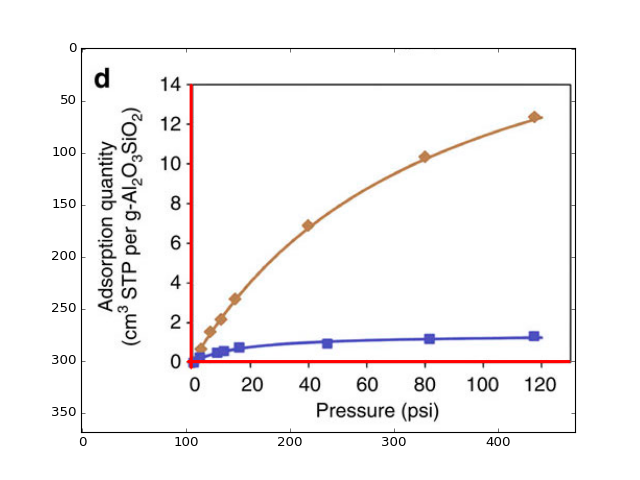

In [4]:
%matplotlib notebook

implot = plt.imshow(imlabel)
implot.set_cmap('gray')

## OCR to find Tick Labels

First we mask the image to read the text below the x-axis, removing the x-axis and its tick labels

<IPython.core.display.Javascript object>


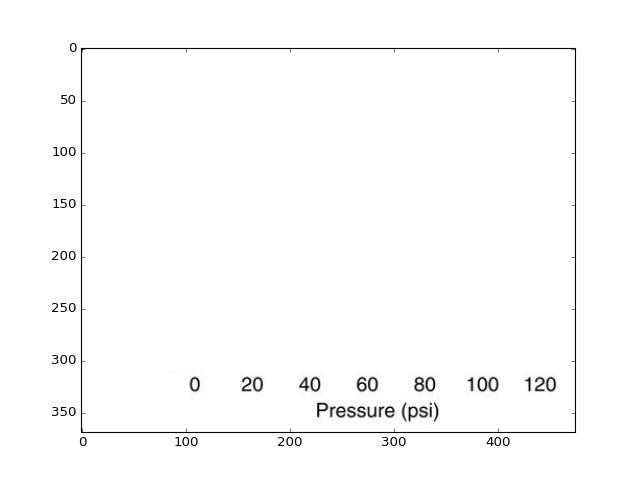

In [5]:
%matplotlib notebook

# Find where the x-ticks stop and crop the text image to be below that
below_xax_bw = np.zeros([m,n]).astype('uint8')
below_xax_bw[xax[1]:,:]=nbw[xax[1]:,:]
row_sums = below_xax_bw.sum(axis=1)
row_sums[0:xax[1]] = 1000
row_sums_list = row_sums.tolist()
text_crop_ind = row_sums_list.index(0)
text_crop_ind

xTextImg = np.ones([m,n,p]).astype('uint8')*255
xTextImg[text_crop_ind+1:,:,:]=img[text_crop_ind+1:,:,:]

cv2.imwrite('temp/xtext.png',xTextImg)
implot = plt.imshow(xTextImg)


In [6]:
xocr = tes.image_to_string(Image.open('temp/xtext.png'),boxes=True)

In [7]:
import ocr_tools

words = ocr_tools.clean_ocr_results(xocr)
words

[['O', 104, 39, 114, 53],
 ['20', 154, 39, 174, 53],
 ['40', 209, 39, 229, 53],
 ['60', 264, 39, 284, 53],
 ['80', 319, 39, 339, 53],
 ['100', 370, 39, 400, 53],
 ['120', 425, 39, 455, 53],
 ['Pressure', 226, 14, 300, 28],
 ['(psi)', 307, 10, 342, 28]]

In [8]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

numbers = [w for w in words if is_number(w[0])]
for w in numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
xt_labels = np.array(numbers)
xt_labels

array([[  20.,  154.,  330.,  174.,  316.,  164.,  323.],
       [  40.,  209.,  330.,  229.,  316.,  219.,  323.],
       [  60.,  264.,  330.,  284.,  316.,  274.,  323.],
       [  80.,  319.,  330.,  339.,  316.,  329.,  323.],
       [ 100.,  370.,  330.,  400.,  316.,  385.,  323.],
       [ 120.,  425.,  330.,  455.,  316.,  440.,  323.]])

<IPython.core.display.Javascript object>


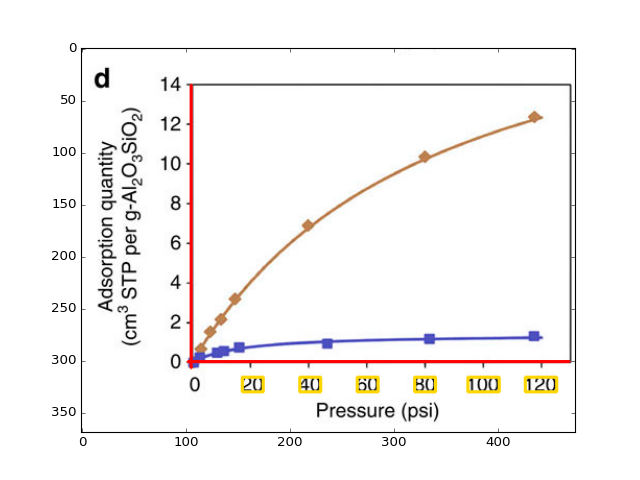

In [9]:
%matplotlib notebook

for w in numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

## Find X Ticks


## More Hough
transform on this image, looking only for vertical lines.

We then sort the results by x-coordinate and remove duplicates that are adjacent to each other by less than 5 pixels.

Finally we accept as ticks vertical lines that are separated from one another by the median spacing of all of the lines.

In [10]:
xt_dirty = find_axes.get_xticks(nbw,xax,tickMargin=11,minTickLen=0,maxGap=0)
xt_list=xt_dirty.tolist()

In [11]:
xt_match = find_axes.match_xticks(numbers,xt_list)
xt_pts = [xt_list[i] for i in xt_match]

<IPython.core.display.Javascript object>


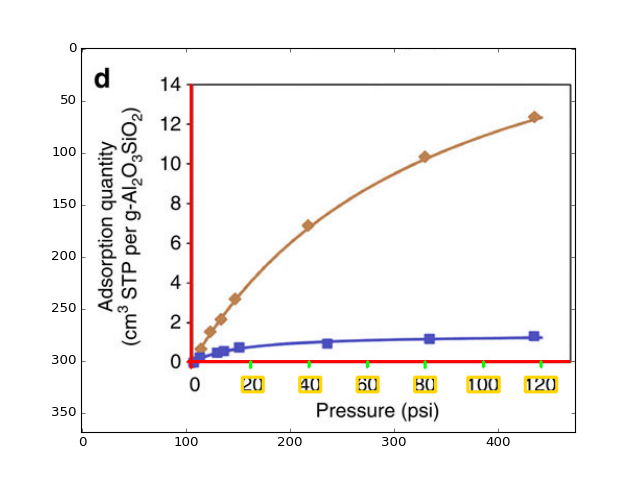

In [12]:
%matplotlib notebook
for x1,y1,x2,y2 in xt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [14]:
xt_pts_array = np.array(xt_pts)
xt_pts_array[:,0].reshape(-1,1)

array([[162],
       [218],
       [274],
       [329],
       [385],
       [440]])

In [15]:
xt_labels[:,0].reshape(-1,1)

array([[  20.],
       [  40.],
       [  60.],
       [  80.],
       [ 100.],
       [ 120.]])

## The moment you've all been waiting for...

### Regress the tick labels against the tick pixel positions to calibrate the x-axis

In [16]:
from sklearn import datasets, linear_model
regrx = linear_model.LinearRegression(fit_intercept=True)

regrx.fit(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regrx.coef_
print 'Intercept: \n', regrx.intercept_

Coefficients: 
[[ 0.35970868]]
Intercept: 
[-38.39221679]


## Now Get Y Ticks

In [17]:
# Find where the y-ticks stop and crop the text image to be left of that
left_yax_bw = np.zeros([m,n]).astype('uint8')
left_yax_bw[:yax[0],:]=nbw[:yax[0],:]
col_sums = left_yax_bw.sum(axis=0)
col_sums[yax[0]:] = 1000
col_zeros=np.where(col_sums==0)[0]
y_crop_ind=col_zeros[-1]

<IPython.core.display.Javascript object>


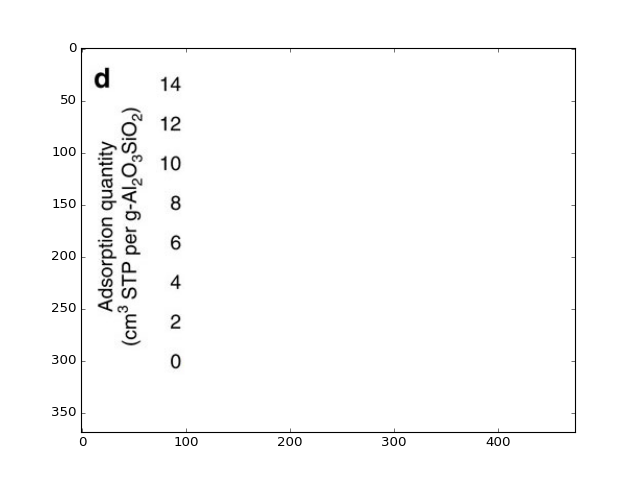

In [18]:
%matplotlib notebook
yTextImg = np.ones([m,n,p]).astype('uint8')*255
yTextImg[:,0:y_crop_ind-1,:]=img[:,0:y_crop_ind-1,:]

cv2.imwrite('temp/ytext.png',yTextImg)
implot = plt.imshow(yTextImg)

## Unfortunately

For OCR to work effectively on the y-axis, we must remove the rotated axis title completely. This is quite challenging.

<IPython.core.display.Javascript object>


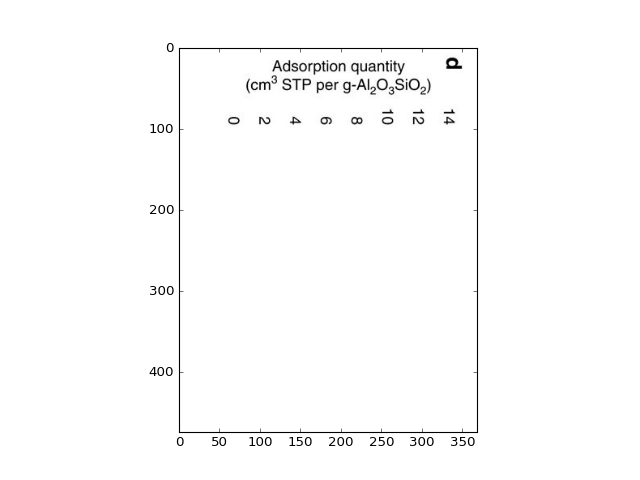

In [19]:
%matplotlib notebook

yTextRot = ndimage.interpolation.rotate(yTextImg, -90)
cv2.imwrite('temp/ytextrot.png',yTextRot)
implot = plt.imshow(yTextRot)
implot.set_cmap('gray')

In [20]:
yRotOcr = tes.image_to_string(Image.open('temp/ytextrot.png'),boxes=True)

### Find the longest "word" and clear its bounding box

In [21]:
yrot_words = ocr_tools.clean_ocr_results(yRotOcr,charspace=10)
word_length = [len(i[0]) for i in yrot_words]
longest_word = np.array(word_length).argmax()
lwbox = yrot_words[longest_word]
lwbox

['Adsorptionquanlity', 115, 440, 279, 458]

In [22]:
x1 = lwbox[1]-1
y1 = lwbox[2]-1
x2 = lwbox[3]+1
y2 = lwbox[4]+1
y1 = n-y1
y2 = n-y2
yTextRot[y2:y1+1,x1:x2+1,:] = np.ones([y1-y2+1,x2-x1+1,3]).astype('uint8')*255
yText_Clean = ndimage.interpolation.rotate(yTextRot, 90)

<IPython.core.display.Javascript object>


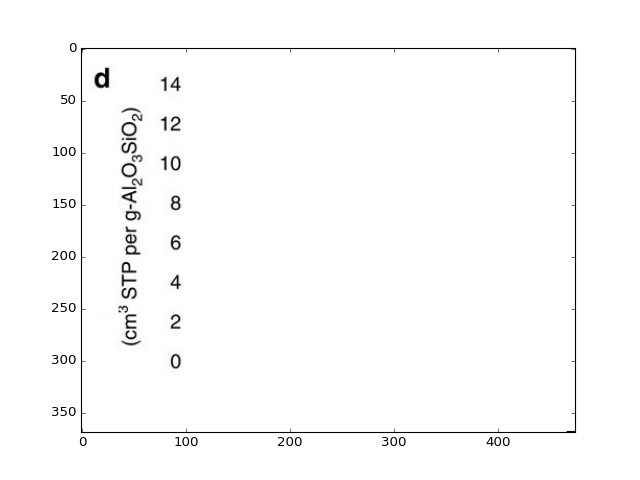

In [23]:
%matplotlib notebook
implot = plt.imshow(yText_Clean)

### Now run conventional OCR

In [24]:
cv2.imwrite('temp/ytextclean.png',yText_Clean)
yocr = tes.image_to_string(Image.open('temp/ytextclean.png'),boxes=True)
yl_ocr = ocr_tools.clean_ocr_results(yocr)
yl_ocr

[['4', 86, 327, 95, 340],
 ['2', 86, 289, 95, 302],
 ['0', 86, 251, 95, 264],
 ['8', 86, 213, 95, 227],
 ['6', 86, 175, 95, 189],
 ['4', 86, 137, 95, 151],
 ['2', 86, 99, 95, 113],
 ['0', 86, 61, 95, 75],
 ['A', 39, 306, 57, 311],
 ['~', 49, 298, 59, 305],
 ['o', 39, 284, 53, 297],
 ['_', 39, 280, 53, 282],
 ['w', 39, 267, 53, 278],
 ['m', 49, 259, 59, 266],
 ['o', 39, 244, 53, 258],
 ['w', 49, 236, 59, 243],
 ['_', 39, 233, 53, 235],
 ['<', 39, 219, 53, 231],
 ['', 47, 213, 49, 218],
 ['m', 43, 203, 57, 212],
 ['.', 43, 192, 53, 197],
 ['m', 43, 180, 53, 190],
 ['a', 43, 170, 57, 179],
 ['m', 39, 153, 53, 163],
 ['p', 39, 140, 53, 151],
 ['m', 39, 128, 53, 139],
 ['HE', 36, 99, 53, 121],
 ['g', 43, 89, 53, 97],
 ['g', 39, 83, 57, 88],
 ['d', 13, 330, 27, 349]]

In [25]:
yt_numbers = [w for w in yl_ocr if is_number(w[0])]
for w in yt_numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
yt_label_array = np.array(yt_numbers)
yt_label_array

array([[   4.,   86.,   42.,   95.,   29.,   90.,   35.],
       [   2.,   86.,   80.,   95.,   67.,   90.,   73.],
       [   0.,   86.,  118.,   95.,  105.,   90.,  111.],
       [   8.,   86.,  156.,   95.,  142.,   90.,  149.],
       [   6.,   86.,  194.,   95.,  180.,   90.,  187.],
       [   4.,   86.,  232.,   95.,  218.,   90.,  225.],
       [   2.,   86.,  270.,   95.,  256.,   90.,  263.],
       [   0.,   86.,  308.,   95.,  294.,   90.,  301.]])

<IPython.core.display.Javascript object>


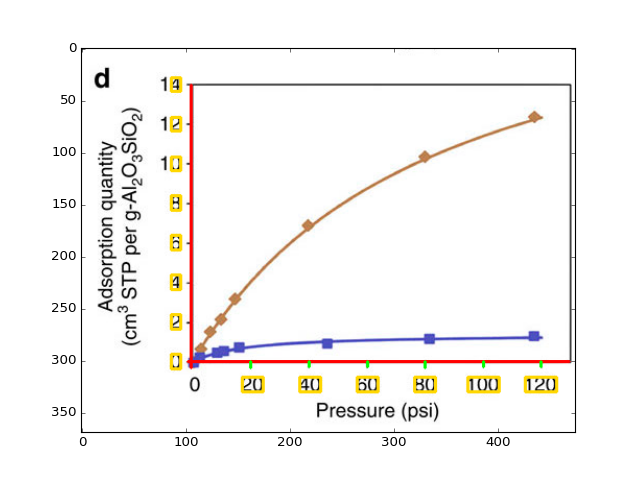

In [26]:
%matplotlib notebook

for w in yt_numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

## Now run the same label/tick matching algorithm for the y-axis

In [27]:
yt_dirty = find_axes.get_yticks(nbw,yax,tickMargin=11,minTickLen=0,maxGap=2)
yt_list=yt_dirty.tolist()

In [28]:
yt_match = find_axes.match_xticks(yt_numbers,yt_list)
yt_pts = [yt_list[i] for i in yt_match]
yt_pts

[[101, 36, 115, 36],
 [94, 73, 94, 73],
 [94, 113, 95, 113],
 [94, 153, 95, 153],
 [94, 190, 95, 190],
 [101, 227, 107, 227],
 [94, 261, 95, 261],
 [94, 301, 95, 301]]

<IPython.core.display.Javascript object>


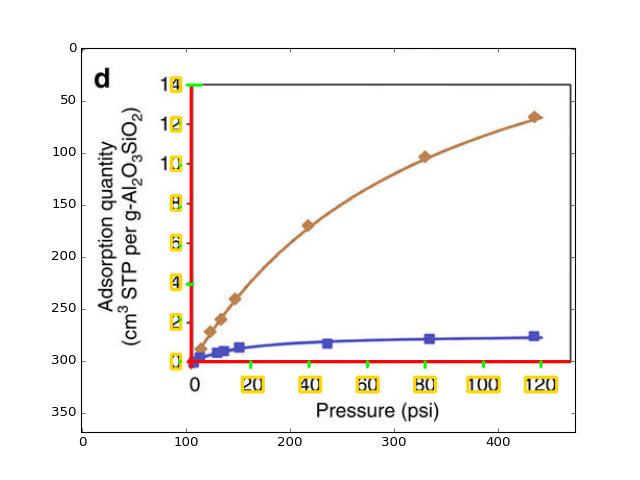

In [29]:
%matplotlib notebook
for x1,y1,x2,y2 in yt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [31]:
yt_pts_array = np.array(yt_pts)
yt_pts_array[:,1].reshape(-1,1)

array([[ 36],
       [ 73],
       [113],
       [153],
       [190],
       [227],
       [261],
       [301]])

In [32]:
yt_label_array[:,0].reshape(-1,1)

array([[ 4.],
       [ 2.],
       [ 0.],
       [ 8.],
       [ 6.],
       [ 4.],
       [ 2.],
       [ 0.]])

## Regress the y tick labels

In [33]:
from sklearn import datasets, linear_model
regry = linear_model.LinearRegression(fit_intercept=True)

regry.fit(yt_pts_array[:,1].reshape(-1,1), yt_label_array[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regry.coef_
print 'Intercept: \n', regry.intercept_

Coefficients: 
[[-0.00527592]]
Intercept: 
[ 4.14295002]


## Finally, Extract the Data

In [38]:
from color_series_scrape import color_series_scrape

pix_pts, ROI = color_series_scrape(example, [[xax[0],xax[2]]],[[yax[3],yax[1]]], n_colors=4)


KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image


KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image


<IPython.core.display.Javascript object>


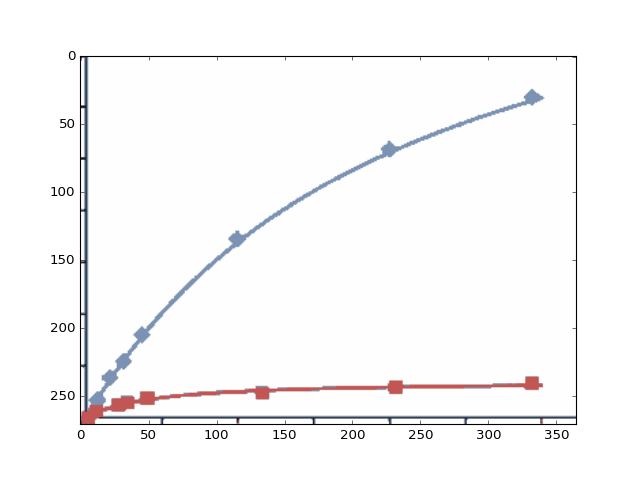

In [39]:
from cluster_data import cluster_colorspace_km, return_series

im_recon, im_label = cluster_colorspace_km(ROI[0], 4)
labels_as_ims = return_series(im_label)

%matplotlib notebook
plt.imshow(im_recon)

<IPython.core.display.Javascript object>


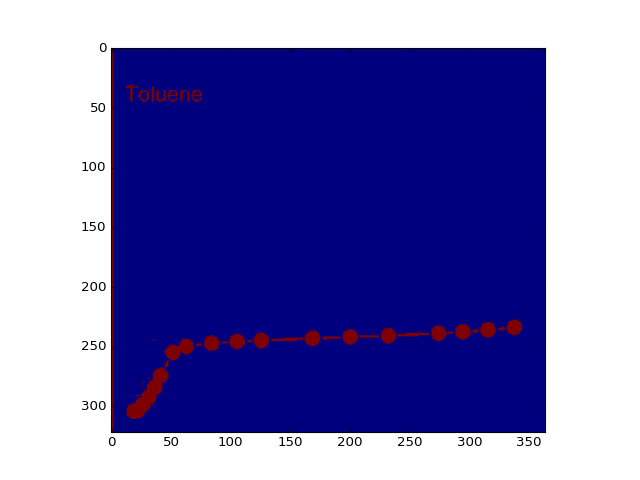

In [41]:
%matplotlib notebook

plt.imshow(labels_as_ims[0])

<IPython.core.display.Javascript object>


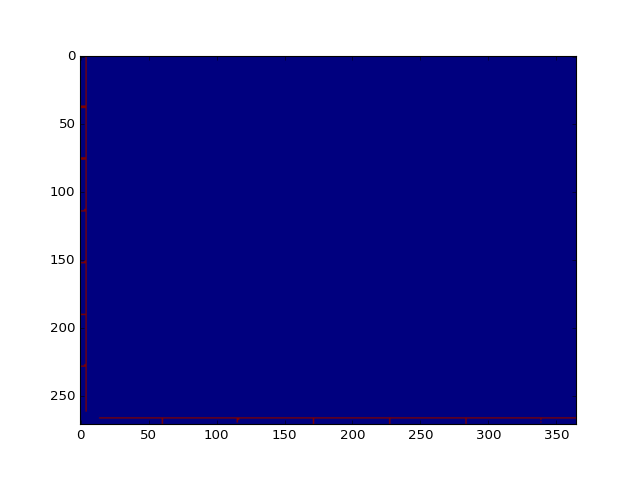

In [40]:
%matplotlib notebook

plt.imshow(labels_as_ims[1])

<IPython.core.display.Javascript object>


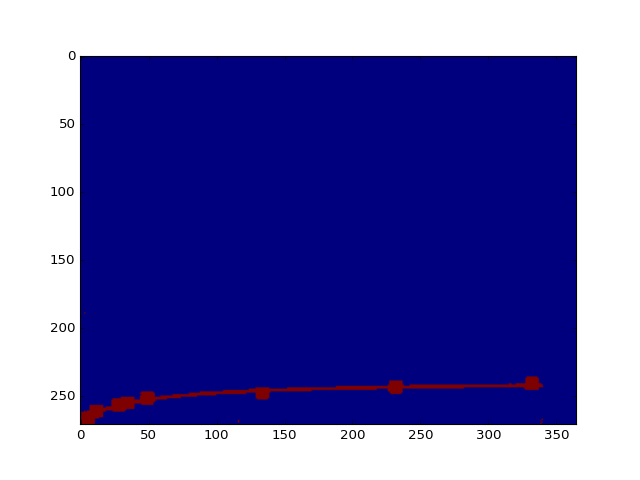

In [41]:
%matplotlib notebook

plt.imshow(labels_as_ims[2])

<IPython.core.display.Javascript object>


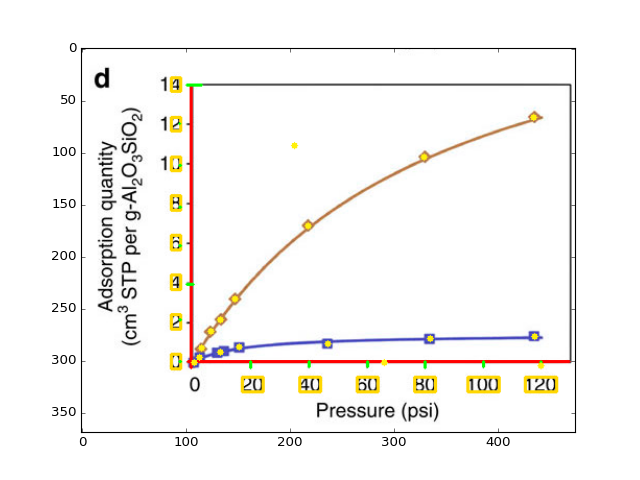

In [42]:
%matplotlib notebook
imlabel4 = imlabel.copy()
pp_list = []
for series in pix_pts[0]:
    s_list = []
    for tup in series:
        x = int(round(tup[1]))+xax[0]
        y = int(round(tup[0]))+yax[3]
        s_list.append([x,y])
    pp_list.append(s_list)

pp_list

for series in pp_list:
    for pt in series:
        cv2.circle(imlabel4,(pt[0],pt[1]), 3, (255,240,10), -1)


lastplot = plt.imshow(imlabel4)

## ... and convert the pixel values to the units of the axes

In [43]:
data_list = []
for series in pp_list:
    ser_list = []
    for pt in series:
        xdata = pt[0]*regrx.coef_+regrx.intercept_
        ydata = pt[1]*regry.coef_+regry.intercept_
        ser_list.append([xdata[0,0],ydata[0,0]])
    data_list.append(ser_list[::-1])

data_list

[[[2.9742818765480976, 2.6234841097192008],
  [6.2116600327792213, 2.707898882304403],
  [9.4490381890103521, 2.7659340384567299],
  [14.484959765369886, 2.8714525041882331],
  [39.664567647167559, 3.2407671342484936],
  [79.592231574018157, 3.5889780711624537],
  [117.36164339671468, 3.7894631560523093]],
 [[119.87960418489443, 2.5337934138474232],
  [65.923301581042281, 2.5496211837071487],
  [34.988354754833708, 3.6470132273147802]],
 [[0.45632108836832685, 2.5496211837071487],
  [2.2548645084967305, 2.5760008001400245],
  [9.4490381890103521, 2.6023804165729003],
  [15.923794501472614, 2.6287600330057761],
  [46.499032643655511, 2.6445878028655017],
  [81.750483678172245, 2.6709674192983774],
  [117.72135208074035, 2.6815192658715272]]]